In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


# Load Data

In [2]:
paths = []
labels = []
for _, folders, _ in os.walk(r'data'):
    for folder in folders:
        for dirname, _, filenames in os.walk(f'data\{folder}'):
            for filename in filenames:
                paths.append(os.path.join(dirname, filename))
                label = folder
                label = label.split('_')[0] # remove to segregate by gender
                labels.append(label.lower())

df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

print('Dataset is Loaded')

Dataset is Loaded


# EDA

<Axes: xlabel='label'>

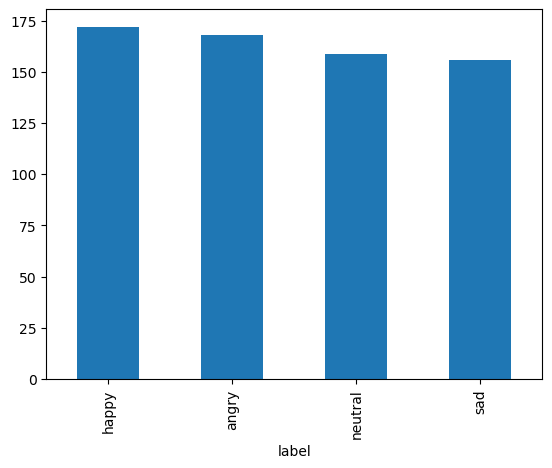

In [124]:
df['label'].value_counts().plot(kind='bar')

In [11]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

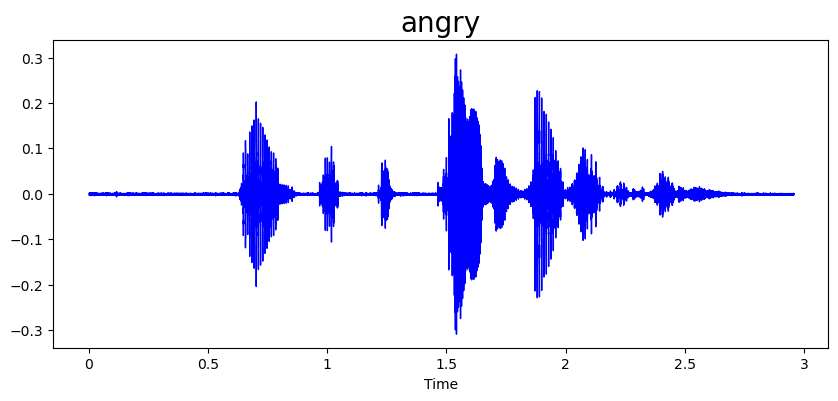

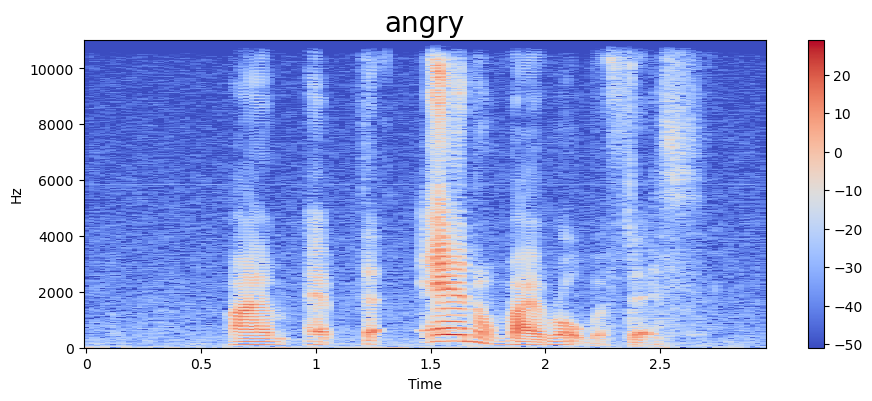

In [132]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[146]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Feature Engineering

In [125]:
from sklearn.preprocessing import OneHotEncoder

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

def processData(df):
    X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
    print(X_mfcc.head())
    X = [x for x in X_mfcc]
    X = np.array(X)
    X = np.expand_dims(X, -1)
    print(X.shape)

    enc = OneHotEncoder()
    y = enc.fit_transform(df[['label']])
    y = y.toarray()
    print(y.shape)
    return X, y

In [126]:
X, y = processData(df)

0    [-494.27545, 134.56302, -25.692623, 44.874004,...
1    [-489.2374, 95.24146, -6.124708, 45.02178, -1....
2    [-520.5528, 101.38984, -10.185469, 41.562035, ...
3    [-490.04434, 127.46854, -25.104696, 38.669407,...
4    [-475.49997, 120.51346, -31.929777, 47.917557,...
Name: speech, dtype: object
(655, 40, 1)
(655, 4)


# Model Training

In [32]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,604 (1.17 MB)

 Trainable params: 305,604 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from sklearn.model_selection import train_test_split

# Separate the test data
x_1, x_test, y_1, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.15, shuffle=True)

# Training the Keras model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9755 - loss: 0.0840 - val_accuracy: 0.9524 - val_loss: 0.1605
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9431 - loss: 0.1488 - val_accuracy: 0.9167 - val_loss: 0.3114
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9423 - loss: 0.2253 - val_accuracy: 0.8810 - val_loss: 0.6252
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9194 - loss: 0.2769 - val_accuracy: 0.9048 - val_loss: 0.2690
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9581 - loss: 0.1659 - val_accuracy: 0.9167 - val_loss: 0.2680
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9386 - loss: 0.2029 - val_accuracy: 0.9167 - val_loss: 0.3260
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9626 - loss: 0.1392 - val_accuracy: 0.8929 - val_loss: 0.2306
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9789 - loss: 0.0920 - val_accuracy: 0.9167 - val_loss: 0.1725


# Model Evaluation

In [115]:
model.evaluate(x=x_test, y=y_test)
predictions = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8828 - loss: 0.3764 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


----- F1 -----
0.8769626688514947
----- AUC ROC -----
0.9874419021587431
----- AUC ROC Curve -----


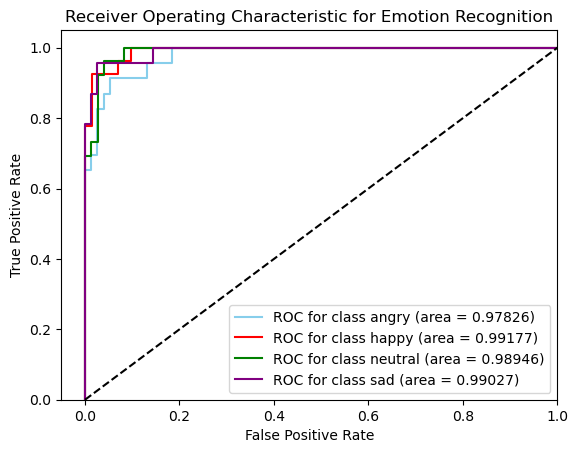

----- Confusion Matrix -----


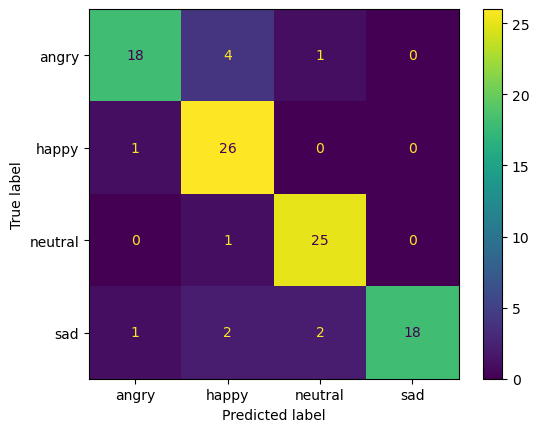

----- Classification Report -----
              precision    recall  f1-score   support

       angry       0.90      0.78      0.84        23
       happy       0.79      0.96      0.87        27
     neutral       0.89      0.96      0.93        26
         sad       1.00      0.78      0.88        23

    accuracy                           0.88        99
   macro avg       0.90      0.87      0.88        99
weighted avg       0.89      0.88      0.88        99



In [113]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    auc,
    roc_auc_score,
    f1_score
)

print("----- F1 -----")
print(f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average="macro"))

print("----- AUC ROC -----")
print(roc_auc_score(y_test, predictions, multi_class="ovr", labels=list(enc.categories_[0])))

print("----- AUC ROC Curve -----")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['skyblue', 'red', 'green', 'purple']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'ROC for class {list(enc.categories_[0])[i]} (area = {roc_auc[i]:.5f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Emotion Recognition')
plt.legend(loc="lower right")
plt.show()


print("----- Confusion Matrix -----")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(enc.categories_[0]))
disp.plot()
plt.show()

print("----- Classification Report -----")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names=list(enc.categories_[0])))


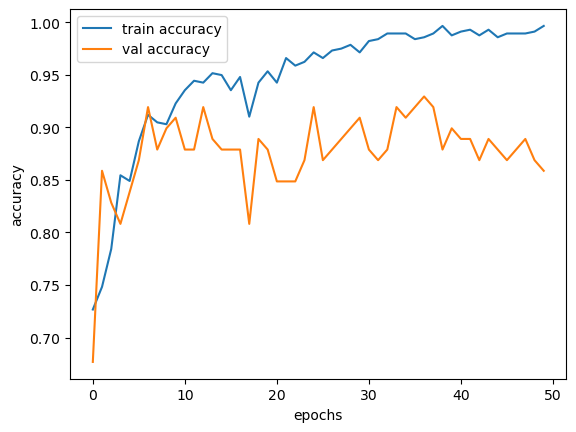

In [41]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

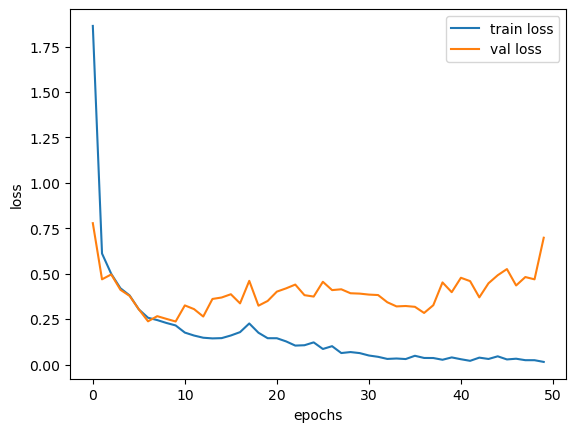

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()